In [ ]:
!pwd

/content


In [ ]:
# @title
%%writefile '/content/drive/MyDrive/Colab Notebooks/rcam/rcam_model.py'

import numpy as np
from dataclasses import dataclass
from typing import Tuple

# ==================== PARAMETERS ====================
@dataclass
class Params:
    """Aircraft parameters container"""
    mass: float = 120000  # kg

    # Aerodynamic parameters
    cbar: float = 6.6
    l: float = 6.6  # mean aerodynamic chord
    lt: float = 24.6  # distance from CoG to AC of tail
    S: float = 260  # wing planform area
    St: float = 64  # tail planform area

    # Center of Gravity location
    xcg: float = 0.23 * 6.6
    ycg: float = 0.0
    zcg: float = 0.10 * 6.6

    # Aerodynamic Center location
    xac: float = 0.12 * 6.6
    yac: float = 0.0
    zac: float = 0.0

    # Engine attachment points
    xapt1: float = 0.0
    yapt1: float = -7.94
    zapt1: float = -1.9

    xapt2: float = 0.0
    yapt2: float = 7.94
    zapt2: float = -1.9

    # Environmental parameters
    rho: float = 1.225  # air density
    g: float = 9.81  # gravitational acceleration


params = Params()

# ==================== INITIALIZATION ====================
x_init = np.array([85, 0, 0, 0, 0, 0, 0, 0.1, 0])  # 9x1 state vector
u_init = np.array([0, -0.1, 0, 0.08, 0.08])  # 5x1 control vector

# Aileron: -0.1502° Elevator: -12.0574° Rudder: -0.3693° Throttle 1: 0.091787 Throttle 2: 0.095224
# u_init = np.array([-0.00262148, -0.210411, -0.006446, 0.091787, 0.095224])  # 5x1 control vector


# ==================== RCAM DYNAMICS MODEL ====================
def rcam(t: float, X: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
    Recursive aircraft model (RCAM) dynamics function.

    Args:
        t: time (not used, included for ODE solver compatibility)
        X: State vector [u, v, w, p, q, r, phi, theta, psi]
        U: Control input [aileron, elevator, rudder, throttle1, throttle2]

    Returns:
        XDot: State derivatives
    """

    # ==================== UNPACK STATE AND CONTROL ====================
    # Control inputs
    u1 = U[0]  # aileron
    u2 = U[1]  # elevator
    u3 = U[2]  # rudder
    u4 = U[3]  # throttle 1
    u5 = U[4]  # throttle 2

    # State variables
    x1 = X[0]  # u (forward velocity)
    x2 = X[1]  # v (lateral velocity)
    x3 = X[2]  # w (vertical velocity)
    x4 = X[3]  # p (roll rate)
    x5 = X[4]  # q (pitch rate)
    x6 = X[5]  # r (yaw rate)
    x7 = X[6]  # phi (roll angle)
    x8 = X[7]  # theta (pitch angle)
    x9 = X[8]  # psi (yaw angle)

    # ==================== AERODYNAMIC CONSTANTS ====================
    depsda = 0.25  # change in downwash wrt alpha
    alpha_L0 = -11.5 * np.pi / 180  # zero lift angle of attack
    n = 5.5  # linear region slope of lift curve
    a3 = -768.5  # coeff of alpha^3
    a2 = 609.2  # coeff of alpha^2
    a1 = -155.2  # coeff of alpha^1
    a0 = 15.212
    alpha_switch = 14.5 * (np.pi / 180)

    # ==================== CONTROL SATURATION ====================
    u1 = np.clip(u1, -25 * np.pi / 180, 10 * np.pi / 180)
    u2 = np.clip(u2, -25 * np.pi / 180, 10 * np.pi / 180)
    u3 = np.clip(u3, -30 * np.pi / 180, 30 * np.pi / 180)
    u4 = np.clip(u4, 0.5 * np.pi / 180, 10 * np.pi / 180)
    u5 = np.clip(u5, 0.5 * np.pi / 180, 10 * np.pi / 180)

    # ==================== INTERMEDIATE VARIABLES ====================
    # Airspeed calculation (accounting for wind)
    Va = np.sqrt(x1**2 + x2**2 + x3**2)

    # Angle of attack and sideslip
    alpha = np.arctan2(x3, x1)
    beta = np.arcsin(np.clip(x2 / Va, -1, 1))  # clip to avoid numerical issues

    # Dynamic pressure
    Q = 0.5 * params.rho * Va**2

    # Velocity and angular velocity vectors in body frame
    V_b = np.array([x1, x2, x3])
    wbe_b = np.array([x4, x5, x6])

    # ==================== AERODYNAMIC FORCE COEFFICIENTS ====================
    # Lift coefficient (wing and body)
    if alpha <= alpha_switch:
        CL_wb = n * (alpha - alpha_L0)
    else:
        CL_wb = a3 * alpha**3 + a2 * alpha**2 + a1 * alpha + a0

    # Tail aerodynamics
    epsilon = depsda * (alpha - alpha_L0)
    alpha_t = alpha - epsilon + u2 + 1.3 * x5 * params.lt / Va
    CL_t = 3.18 * (params.St / params.S) * alpha_t  # FIXED: Added missing * operator

    # Total lift coefficient
    CL = CL_wb + CL_t

    # Drag coefficient (neglecting tail)
    CD = 0.13 + 0.07 * (5.5 * alpha + 0.654)**2

    # Side force coefficient
    CY = -1.6 * beta + 0.24 * u3

    # ==================== DIMENSIONAL AERODYNAMIC FORCES ====================
    # Forces in stability axis frame
    FA_s = np.array([
        -CD * Q * params.S,
        CY * Q * params.S,
        -CL * Q * params.S
    ])

    # Rotation matrix from stability to body frame
    C_bs = np.array([
        [np.cos(alpha), 0, -np.sin(alpha)],
        [0, 1, 0],
        [np.sin(alpha), 0, np.cos(alpha)]
    ])

    # Forces in body frame
    FA_b = C_bs @ FA_s  # FIXED: Case consistency and proper matrix multiplication

    # ==================== AERODYNAMIC MOMENT COEFFICIENTS ====================
    eta11 = -1.4 * beta
    eta21 = -0.59 - (3.2 * (params.St / params.lt) / (params.S * params.l)) * (alpha - epsilon)
    eta31 = (1 - alpha * (180 / (15 * np.pi))) * beta
    eta = np.array([eta11, eta21, eta31])

    # Moment derivatives w.r.t. angular velocities
    dCMdx = (params.l / Va) * np.array([
        [-11, 0, 5],
        [0, -4.03 * (params.St * params.lt) / (params.S * params.l**2), 0],
        [1.7, 0, -11.5]
    ])

    # Moment derivatives w.r.t. control inputs
    dCMdu = np.array([
        [-0.6, 0, 0.22],
        [0, -3.1 * (params.St * params.lt) / (params.S * params.l), 0],
        [0, 0, -0.63]
    ])

    # Moment coefficients about aerodynamic center in body frame
    CMac_b = eta + dCMdx @ wbe_b + dCMdu @ np.array([u1, u2, u3])

    # ==================== AERODYNAMIC MOMENT ====================
    MAac_b = CMac_b * Q * params.S * params.l

    # ==================== TRANSFER MOMENT TO CG ====================
    rcg_b = np.array([params.xcg, params.ycg, params.zcg])
    rac_b = np.array([params.xac, params.yac, params.zac])

    MAcg_b = MAac_b + np.cross(FA_b, rcg_b - rac_b)

    # ==================== ENGINE FORCES ====================
    Tmax = params.mass * params.g
    F1 = u4 * Tmax
    F2 = u5 * Tmax

    # Engine thrust (assumed forward direction only)
    FE1_b = np.array([F1, 0, 0])
    FE2_b = np.array([F2, 0, 0])

    FE_b = FE1_b + FE2_b

    # ==================== ENGINE MOMENTS ====================
    # Moment arms from CG to engine attachment points
    mew1 = np.array([
        params.xcg - params.xapt1,
        params.yapt1 - params.ycg,
        params.zcg - params.zapt1
    ])

    mew2 = np.array([
        params.xcg - params.xapt2,  # FIXED: Was params.xch
        params.yapt2 - params.ycg,
        params.zcg - params.zapt2
    ])

    # Engine moments about CG
    MEcg1_b = np.cross(mew1, FE1_b)
    MEcg2_b = np.cross(mew2, FE2_b)

    MEcg_b = MEcg1_b + MEcg2_b

    # ==================== GRAVITY FORCES ====================
    # Gravity vector in body frame (causes no moment about CoG)
    g_b = np.array([
        -params.g * np.sin(x8),  # FIXED: Changed g to params.g
        params.g * np.cos(x8) * np.sin(x7),
        params.g * np.cos(x8) * np.cos(x7)
    ])

    Fg_b = params.mass * g_b

    # ==================== STATE DERIVATIVES ====================
    # Inertia matrix (constant)
    Ib = np.array([
        [40.07, 0, -2.0923],
        [0, 64, 0],
        [-2.0923, 0, 99.92]
    ]) # * params.mass

    # Inverse inertia matrix
    # invIb = (1 / params.mass) * np.array([
    #     [0.0249836, 0, 0.000523151],
    #     [0, 0.015625, 0],
    #     [0.000523151, 0, 0.0100191]
    # ])

    invIb = np.linalg.inv(Ib)

    # Total forces and linear accelerations
    F_b = Fg_b + FE_b + FA_b
    x1tox3dot = (1 / params.mass) * F_b - np.cross(wbe_b, V_b)

    # Total moments and angular accelerations
    Mcg_b = MAcg_b + MEcg_b
    x4tox6dot = invIb @ (Mcg_b - np.cross(wbe_b, Ib @ wbe_b))

    # Euler angle derivatives
    H_phi = np.array([
        [1, np.sin(x7) * np.tan(x8), np.cos(x7) * np.tan(x8)],
        [0, np.cos(x7), -np.sin(x7)],
        [0, np.sin(x7) / np.cos(x8), np.cos(x7) / np.cos(x8)]
    ])

    x7tox9dot = H_phi @ wbe_b

    # ==================== ASSEMBLE STATE DERIVATIVE VECTOR ====================
    XDot = np.concatenate([x1tox3dot, x4tox6dot, x7tox9dot])  # FIXED: Was x3tox6dor

    return XDot


# ==================== EXAMPLE USAGE ====================
if __name__ == "__main__":
    # Test the dynamics function
    t = 0
    X = x_init.copy()
    U = u_init.copy()

    XDot = rcam(t, X, U)
    print("State derivatives at t=0:")
    print(XDot)
    print(f"\nState shape: {X.shape}")
    print(f"Control shape: {U.shape}")
    print(f"XDot shape: {XDot.shape}")

Overwriting /content/drive/MyDrive/Colab Notebooks/rcam/rcam_model.py


In [ ]:
# TESTING EQUILIBRUM CONTROLS

x_equi_test = np.array([85, 0, 0, 0, 0, 0, 0, 0.1, 0])  # 9x1 state vector
# u_init = np.array([0, -0.1, 0, 0.08, 0.08])  # 5x1 control vector

# Aileron: -0.1502° Elevator: -12.0574° Rudder: -0.3693° Throttle 1: 0.091787 Throttle 2: 0.095224
u_equi_test = np.array([-0.00262148, -0.210411, -0.006446, 0.091787, 0.095224])  # 5x1 control vector

XDot_equi_test = rcam(0, x_equi_test, u_equi_test)
print("State derivatives at t=0:")
print(XDot_equi_test)
print(f"\nState shape: {x_equi_test.shape}")
print(f"Control shape: {u_equi_test.shape}")
print(f"XDot shape: {XDot_equi_test.shape}")

State derivatives at t=0:
[ -0.6783221   -0.01483329   1.13221127   0.01484408 -10.68499752
   0.05199864   0.           0.           0.        ]

State shape: (9,)
Control shape: (5,)
XDot shape: (9,)


In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


import sys
PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/rcam/"

if PROJECT_ROOT not in sys.path:
  sys.path.insert(0, PROJECT_ROOT)

print("Project ready: ", PROJECT_ROOT)


"""
RCAM Aircraft Dynamics Simulator
Example showing how to simulate the aircraft model over time
"""

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

import importlib
import rcam_model
importlib.reload(rcam_model)
from rcam_model import rcam, params, x_init, u_init

Mounted at /content/drive
Project ready:  /content/drive/MyDrive/Colab Notebooks/rcam/


In [ ]:
# @title
# ==================== CONTROL INPUT PROFILE ====================
def get_control_input(t: float) -> np.ndarray:
    """
    Define control inputs as a function of time.
    This is a simple example; modify as needed for your scenario.
    """
    # u = u_init.copy()
    u = np.array([-0.00262148, -0.210411, -0.006446, 0.091787, 0.095224]) # equilibrum controls
    # if t < 2 or t > 4:
    #     u[1] = 0  # aileron command
    #     u[2] = 0

    # # Example: Introduce a step in elevator at t=10s
    # if t > 10:
    #     u[1] = -0.05  # elevator command

    return u

In [ ]:
# ==================== ODE WRAPPER ====================
def rcam_wrapper(X: np.ndarray, t: float) -> np.ndarray:
    """
    Wrapper for ODE solver that provides time-varying control inputs.
    """
    U = get_control_input(t)
    return rcam(t, X, U)


In [ ]:
# ==================== SIMULATION CONFIGURATION ====================
t_start = 0.0
t_end = 200.0
dt = 0.01
teval= np.arange(t_start, t_end, dt)
num_steps = len(teval)

# ==================== SIMULATION ====================
print("Starting RCAM simulation...")
print(f"Simulation duration: {t_start} to {t_end} seconds")
print(f"Number of steps: {num_steps}")

# Run simulation using scipy's odeint
# X_trajectory = odeint(rcam_wrapper, x_init, time)

sol = solve_ivp(
    lambda t, x: rcam(t, x, get_control_input(t)),
    [t_start, t_end],
    x_init,
    method="Radau",
    #max_step=dt,
    #t_eval=teval,
    rtol=1e-6,
    atol=1e-9
)

time = sol.t
X_trajectory = sol.y.T

print("Success:", sol.success)
print("Message:", sol.message)
print("Final time reached:", sol.t[-1])
print("Expected final time:", t_end)


print(f"Simulation complete!")
print(f"Trajectory shape: {X_trajectory}")
print(f"Trajectory shape: {X_trajectory.shape} {time.shape}")

# ==================== EXTRACT STATE COMPONENTS ====================
u_vel = X_trajectory[:, 0]  # forward velocity
v_vel = X_trajectory[:, 1]  # lateral velocity
w_vel = X_trajectory[:, 2]  # vertical velocity
p_rate = X_trajectory[:, 3]  # roll rate
q_rate = X_trajectory[:, 4]  # pitch rate
r_rate = X_trajectory[:, 5]  # yaw rate
phi = X_trajectory[:, 6]    # roll angle
theta = X_trajectory[:, 7]  # pitch angle
psi = X_trajectory[:, 8]    # yaw angle

# Calculate derived quantities
airspeed = np.sqrt(u_vel**2 + v_vel**2 + w_vel**2)
phi_deg = np.degrees(phi)
theta_deg = np.degrees(theta)
psi_deg = np.degrees(psi)

Starting RCAM simulation...
Simulation duration: 0.0 to 500.0 seconds
Number of steps: 50000


KeyboardInterrupt: 

In [ ]:
# ==================== PRINT KEY RESULTS ====================
print("\n" + "="*60)
print("SIMULATION RESULTS")
print("="*60)
print(f"Initial State: {x_init}")
print(f"Initial Control: {u_init}")
print(f"\nFinal State: {X_trajectory[-1]}")
print(f"\nAirspeed Range: {airspeed.min():.2f} to {airspeed.max():.2f} m/s")
print(f"Roll Angle Range: {phi_deg.min():.2f}° to {phi_deg.max():.2f}°")
print(f"Pitch Angle Range: {theta_deg.min():.2f}° to {theta_deg.max():.2f}°")
print(f"Yaw Angle Range: {psi_deg.min():.2f}° to {psi_deg.max():.2f}°")


SIMULATION RESULTS
Initial State: [85.   0.   0.   0.   0.   0.   0.   0.1  0. ]
Initial Control: [ 0.   -0.1   0.    0.08  0.08]

Final State: [ 1.03009047e+02  4.86557924e-02 -3.42281900e+00  1.82068015e-04
 -3.52578507e-04  2.70044194e-03  3.17473703e-02 -6.18423334e-02
  4.48639994e-01]

Airspeed Range: 83.40 to 113.58 m/s
Roll Angle Range: -0.02° to 2.63°
Pitch Angle Range: -9.91° to 5.73°
Yaw Angle Range: -0.10° to 25.71°


Plot saved to rcam_simulation.png


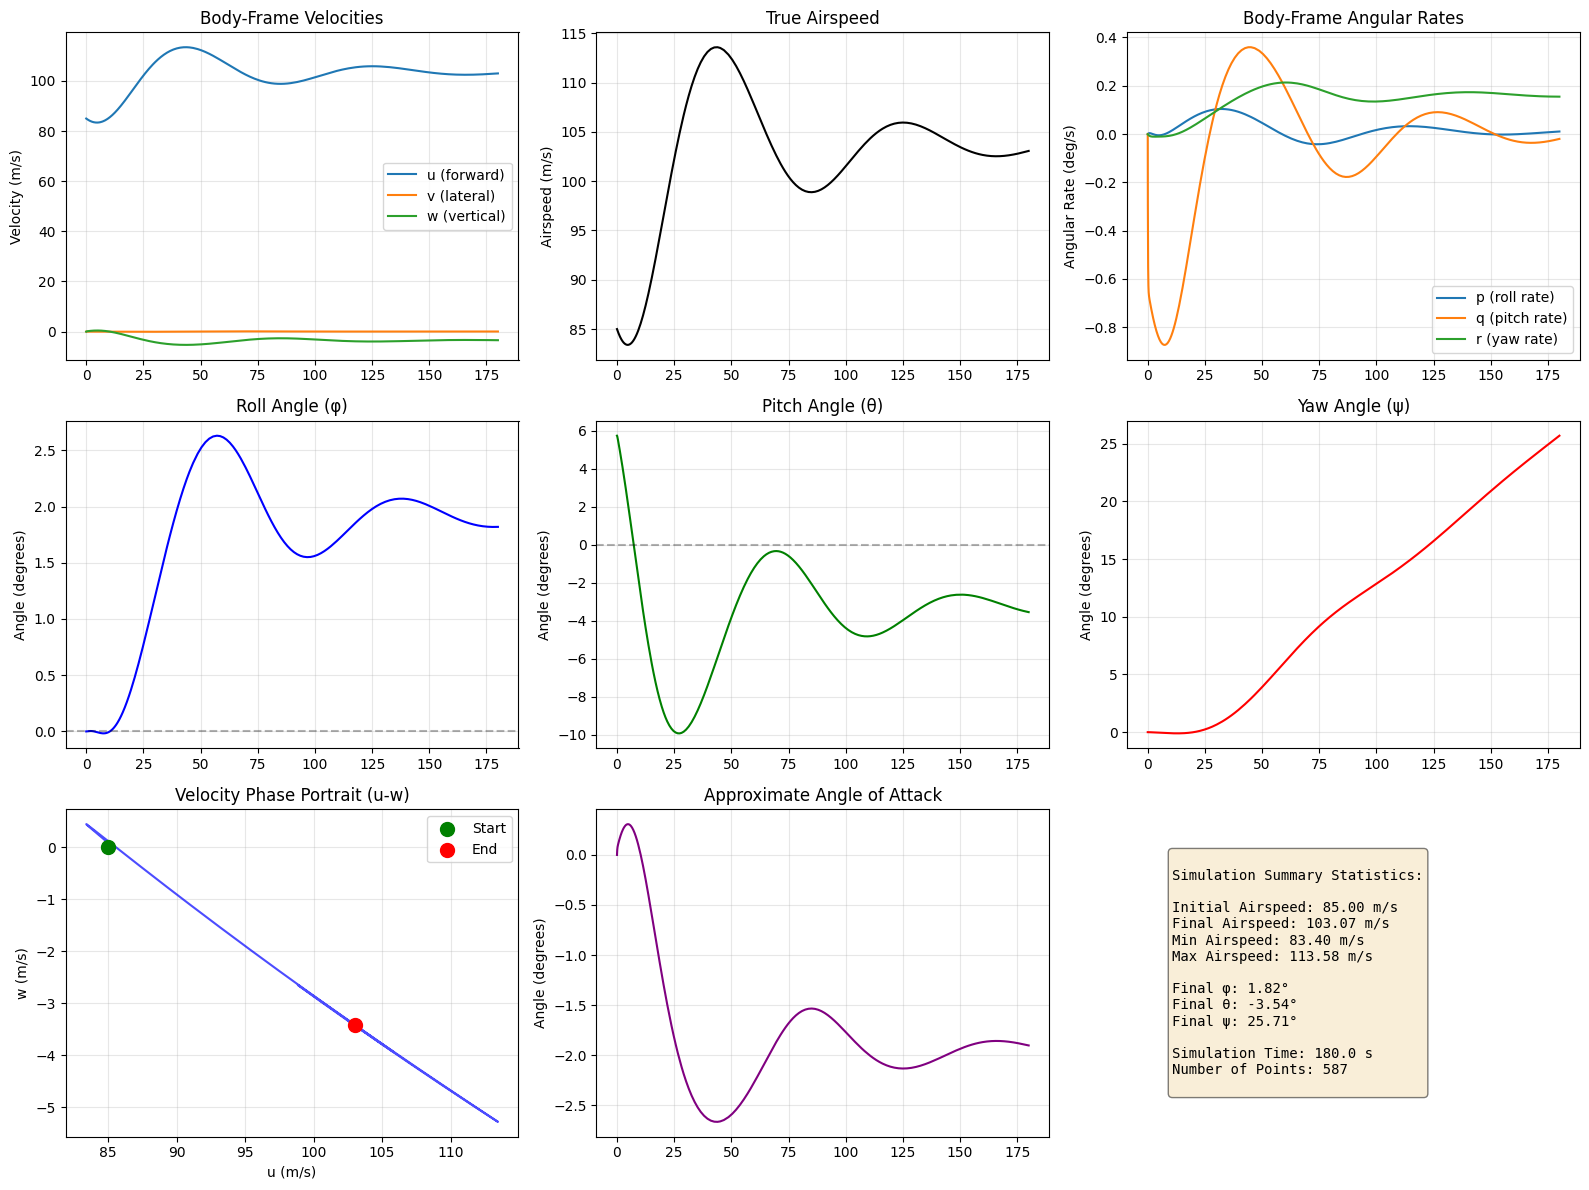

Trajectory saved to rcam_trajectory.csv


In [ ]:
# ==================== PLOTTING ====================
fig = plt.figure(figsize=(16, 12))

# Velocities
ax1 = plt.subplot(3, 3, 1)
ax1.plot(time, u_vel, label='u (forward)', linewidth=1.5)
ax1.plot(time, v_vel, label='v (lateral)', linewidth=1.5)
ax1.plot(time, w_vel, label='w (vertical)', linewidth=1.5)
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Body-Frame Velocities')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Airspeed
ax2 = plt.subplot(3, 3, 2)
ax2.plot(time, airspeed, 'k-', linewidth=1.5)
ax2.set_ylabel('Airspeed (m/s)')
ax2.set_title('True Airspeed')
ax2.grid(True, alpha=0.3)

# Angular rates
ax3 = plt.subplot(3, 3, 3)
ax3.plot(time, np.degrees(p_rate), label='p (roll rate)', linewidth=1.5)
ax3.plot(time, np.degrees(q_rate), label='q (pitch rate)', linewidth=1.5)
ax3.plot(time, np.degrees(r_rate), label='r (yaw rate)', linewidth=1.5)
ax3.set_ylabel('Angular Rate (deg/s)')
ax3.set_title('Body-Frame Angular Rates')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Roll angle
ax4 = plt.subplot(3, 3, 4)
ax4.plot(time, phi_deg, 'b-', linewidth=1.5)
ax4.set_ylabel('Angle (degrees)')
ax4.set_title('Roll Angle (φ)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Pitch angle
ax5 = plt.subplot(3, 3, 5)
ax5.plot(time, theta_deg, 'g-', linewidth=1.5)
ax5.set_ylabel('Angle (degrees)')
ax5.set_title('Pitch Angle (θ)')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Yaw angle
ax6 = plt.subplot(3, 3, 6)
ax6.plot(time, psi_deg, 'r-', linewidth=1.5)
ax6.set_ylabel('Angle (degrees)')
ax6.set_title('Yaw Angle (ψ)')
ax6.grid(True, alpha=0.3)

# Phase portrait: u vs w
ax7 = plt.subplot(3, 3, 7)
ax7.plot(u_vel, w_vel, 'b-', linewidth=1.5, alpha=0.7)
ax7.scatter([u_vel[0]], [w_vel[0]], color='g', s=100, label='Start', zorder=5)
ax7.scatter([u_vel[-1]], [w_vel[-1]], color='r', s=100, label='End', zorder=5)
ax7.set_xlabel('u (m/s)')
ax7.set_ylabel('w (m/s)')
ax7.set_title('Velocity Phase Portrait (u-w)')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Angle of attack approximation
alpha_approx = np.arctan2(w_vel, u_vel)
ax8 = plt.subplot(3, 3, 8)
ax8.plot(time, np.degrees(alpha_approx), 'purple', linewidth=1.5)
ax8.set_ylabel('Angle (degrees)')
ax8.set_title('Approximate Angle of Attack')
ax8.grid(True, alpha=0.3)

# Summary statistics
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
stats_text = f"""
Simulation Summary Statistics:

Initial Airspeed: {airspeed[0]:.2f} m/s
Final Airspeed: {airspeed[-1]:.2f} m/s
Min Airspeed: {airspeed.min():.2f} m/s
Max Airspeed: {airspeed.max():.2f} m/s

Final φ: {phi_deg[-1]:.2f}°
Final θ: {theta_deg[-1]:.2f}°
Final ψ: {psi_deg[-1]:.2f}°

Simulation Time: {t_end - t_start:.1f} s
Number of Points: {len(time)}
"""
ax9.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10,
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/rcam/plot"

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/rcam_simulation.png', dpi=150, bbox_inches='tight')
print("Plot saved to rcam_simulation.png")
plt.show()

# ==================== DATA EXPORT ====================
# Save trajectory to CSV for further analysis
data = np.column_stack([
    time, u_vel, v_vel, w_vel, p_rate, q_rate, r_rate,
    phi_deg, theta_deg, psi_deg, airspeed, np.degrees(alpha_approx)
])

header = 'time,u,v,w,p,q,r,phi_deg,theta_deg,psi_deg,airspeed,alpha_deg'
np.savetxt(f'{SAVE_DIR}/rcam_trajectory.csv', data, delimiter=',', header=header, comments='')
print("Trajectory saved to rcam_trajectory.csv")

In [ ]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/rcam/equilibrum.py'

"""
RCAM Straight-Level Flight Equilibrium Finder
Finds control inputs (U) that achieve straight-level flight conditions
Uses scipy.optimize.minimize with trust-constr method
"""

import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import matplotlib.pyplot as plt
from rcam_model import rcam, params, x_init, u_init

# ==================== EQUILIBRIUM COST FUNCTION ====================

def equilibrium_cost(U_opt: np.ndarray, target_airspeed: float = 85.0) -> float:
    """
    Cost function for equilibrium: minimize state derivatives.

    For straight-level flight, we want:
    - Pitch rate (q) ≈ 0
    - Roll rate (p) ≈ 0
    - Yaw rate (r) ≈ 0
    - Pitch angle (theta) ≈ 0 (level flight)
    - Roll angle (phi) ≈ 0 (wings level)
    - Vertical velocity (w) ≈ 0

    Args:
        U_opt: Control inputs [aileron, elevator, rudder, throttle1, throttle2]
        target_airspeed: Desired airspeed in m/s

    Returns:
        Cost (float): Sum of squared state derivatives (penalizing motion)
    """

    # State for equilibrium: cruising at target airspeed, level, wings level
    X_eq = np.array([
        target_airspeed,  # u: forward velocity
        0.0,              # v: lateral velocity
        0.0,              # w: vertical velocity
        0.0,              # p: roll rate
        0.0,              # q: pitch rate
        0.0,              # r: yaw rate
        0.0,              # phi: roll angle
        0.0,              # theta: pitch angle
        0.0               # psi: yaw angle (doesn't matter for straight flight)
    ])

    # Calculate state derivatives at this condition
    t = 0
    X_dot = rcam(t, X_eq, U_opt)

    # Cost: weighted sum of squared derivatives
    # Prioritize zeroing angular rates and vertical velocity
    weights = np.array([
        10.0,   # u_dot: maintain airspeed
        50.0,   # v_dot: minimize lateral velocity change
        50.0,   # w_dot: minimize vertical velocity change
        100.0,  # p_dot: minimize roll rate change
        100.0,  # q_dot: minimize pitch rate change
        100.0,  # r_dot: minimize yaw rate change
        10.0,   # phi_dot: (should be zero naturally from p=0)
        10.0,   # theta_dot: (should be zero naturally from q=0)
        1.0     # psi_dot: (doesn't matter for straight flight)
    ])

    cost = np.sum(weights * X_dot**2)
    return cost


def equilibrium_cost_with_state_error(U_and_state: np.ndarray, target_airspeed: float = 85.0) -> float:
    """
    Alternative cost function that also penalizes deviations from desired state.
    Allows finding equilibrium at specific flight conditions.

    Args:
        U_and_state: [U (8D), X (9D)] concatenated vector
        target_airspeed: Desired airspeed

    Returns:
        Cost combining state error and derivatives
    """
    U_opt = U_and_state[:8]
    X_opt = U_and_state[8:17]  # Only first 9 states (not 12)

    # Desired state: straight-level flight at target airspeed
    X_desired = np.array([
        target_airspeed,  # u
        0.0,              # v
        0.0,              # w
        0.0,              # p
        0.0,              # q
        0.0,              # r
        0.0,              # phi
        0.0,              # theta
        0.0               # psi
    ])

    # State error cost
    state_weights = np.array([5.0, 50.0, 50.0, 50.0, 50.0, 50.0, 20.0, 20.0, 1.0])
    state_error_cost = np.sum(state_weights * (X_opt - X_desired)**2)

    # Derivative cost
    X_dot = rcam(0, X_opt, U_opt)
    derivative_weights = np.array([10.0, 50.0, 50.0, 100.0, 100.0, 100.0, 10.0, 10.0, 1.0])
    derivative_cost = np.sum(derivative_weights * X_dot**2)

    total_cost = state_error_cost + derivative_cost
    return total_cost


# ==================== CONSTRAINT FUNCTIONS ====================

def state_derivative_constraint(U_opt: np.ndarray, target_airspeed: float = 85.0) -> np.ndarray:
    """
    Constraint: State derivatives should be zero for equilibrium.
    This is used as a nonlinear constraint in the optimization.

    Args:
        U_opt: Control inputs
        target_airspeed: Desired airspeed

    Returns:
        Array of state derivatives (should be ≈ 0)
    """
    X_eq = np.array([target_airspeed, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    X_dot = rcam(0, X_eq, U_opt)
    return X_dot


# ==================== OPTIMIZATION SETUP ====================

def find_equilibrium(target_airspeed: float = 85.0,
                     method: str = 'cost_only',
                     verbose: bool = True) -> dict:
    """
    Find straight-level flight equilibrium conditions.

    Args:
        target_airspeed: Desired airspeed (m/s)
        method: 'cost_only' or 'with_constraints'
        verbose: Print optimization details

    Returns:
        Dictionary with optimization results and equilibrium control/state
    """

    print(f"\n{'='*70}")
    print(f"RCAM EQUILIBRIUM FINDER - Straight-Level Flight")
    print(f"{'='*70}")
    print(f"Target Airspeed: {target_airspeed} m/s")
    print(f"Method: {method}")

    # Initial guess: use provided initial controls
    U0 = u_init.copy()

    # Bounds for control inputs (in radians and normalized thrust)
    bounds = [
        (-25*np.pi/180, 10*np.pi/180),   # u1: aileron
        (-25*np.pi/180, 10*np.pi/180),   # u2: elevator
        (-30*np.pi/180, 30*np.pi/180),   # u3: rudder
        (0.5*np.pi/180, 10*np.pi/180),   # u4: throttle 1
        (0.5*np.pi/180, 10*np.pi/180),   # u5: throttle 2
    ]

    # ==================== METHOD 1: Cost-only Minimization ====================
    if method == 'cost_only':
        print("\nUsing cost function minimization (derivatives ≈ 0)...")

        options = {
            'maxiter': 1000,
            'verbose': 1 if verbose else 0,
            'gtol': 1e-6,
        }

        result = minimize(
            equilibrium_cost,
            U0,
            args=(target_airspeed,),
            method='trust-constr',
            bounds=bounds,
            options=options
        )

    # ==================== METHOD 2: With Constraints ====================
    elif method == 'with_constraints':
        print("\nUsing constrained optimization (X_dot = 0 as constraint)...")

        # Nonlinear constraint: state derivatives should be zero
        constraint = NonlinearConstraint(
            lambda U: state_derivative_constraint(U, target_airspeed),
            np.zeros(9),  # lower bound
            np.zeros(9)   # upper bound
        )

        options = {
            'maxiter': 1000,
            'verbose': 1 if verbose else 0,
        }

        result = minimize(
            equilibrium_cost,
            U0,
            args=(target_airspeed,),
            method='trust-constr',
            bounds=bounds,
            constraints=constraint,
            options=options
        )

    else:
        raise ValueError(f"Unknown method: {method}")

    # ==================== EXTRACT AND VERIFY RESULTS ====================

    U_opt = result.x

    # Calculate equilibrium state and derivatives
    X_eq = np.array([target_airspeed, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    X_dot_eq = rcam(0, X_eq, U_opt)

    # Calculate actual airspeed with wind
    actual_airspeed = np.sqrt(
        X_eq[0]**2 +
        X_eq[1]**2 +
        X_eq[2]**2
    )

    # Package results
    results = {
        'success': result.success,
        'message': result.message,
        'nit': result.nit,
        'nfev': result.nfev,
        'cost': result.fun,
        'U_optimal': U_opt,
        'X_equilibrium': X_eq,
        'X_dot_equilibrium': X_dot_eq,
        'max_derivative': np.max(np.abs(X_dot_eq)),
        'target_airspeed': target_airspeed,
        'actual_airspeed': actual_airspeed,
    }

    return results


def find_equilibrium_multipoint(airspeed_range: np.ndarray = None,
                                method: str = 'cost_only') -> dict:
    """
    Find equilibrium conditions across a range of airspeeds.

    Args:
        airspeed_range: Array of target airspeeds to optimize
        method: Optimization method

    Returns:
        Dictionary with results for each airspeed
    """
    if airspeed_range is None:
        airspeed_range = np.linspace(50, 120, 15)

    results_dict = {}

    print(f"\n{'='*70}")
    print(f"MULTI-POINT EQUILIBRIUM ANALYSIS")
    print(f"{'='*70}")
    print(f"Analyzing {len(airspeed_range)} airspeeds from {airspeed_range[0]:.1f} to {airspeed_range[-1]:.1f} m/s\n")

    for i, Va in enumerate(airspeed_range):
        print(f"[{i+1}/{len(airspeed_range)}] Va = {Va:.1f} m/s...", end='', flush=True)

        result = find_equilibrium(target_airspeed=Va, method=method, verbose=False)
        results_dict[Va] = result

        status = "✓" if result['success'] else "✗"
        print(f" {status} (cost: {result['cost']:.6f}, max_deriv: {result['max_derivative']:.6e})")

    return results_dict


# ==================== PLOTTING UTILITIES ====================

def plot_equilibrium_results(result: dict, figsize: tuple = (14, 10)):
    """
    Plot the equilibrium condition results.

    Args:
        result: Dictionary from find_equilibrium()
        figsize: Figure size
    """

    U_opt = result['U_optimal']
    X_dot_eq = result['X_equilibrium']
    cost = result['cost']

    fig = plt.figure(figsize=figsize)

    # Control inputs
    ax1 = plt.subplot(2, 3, 1)
    labels = ['Aileron', 'Elevator', 'Rudder', 'Throttle 1', 'Throttle 2']
    colors = ['b', 'g', 'r', 'orange', 'purple', 'brown', 'pink', 'gray']

    x_pos = np.arange(len(labels))
    heights = np.concatenate([np.degrees(U_opt[:3]),  [U_opt[3]*180/np.pi, U_opt[4]*180/np.pi]])
    ax1.bar(x_pos[:5], heights,
            color=colors[:5], alpha=0.7)
    ax1.set_xticks(x_pos[:5])
    ax1.set_xticklabels(labels[:5], rotation=45, ha='right')
    ax1.set_ylabel('Control Input (deg or normalized)')
    ax1.set_title('Optimal Control Inputs (First 5)')
    ax1.grid(True, alpha=0.3)


    # State derivatives
    ax3 = plt.subplot(2, 3, 2)
    state_labels = ['u', 'v', 'w', 'p', 'q', 'r', 'φ', 'θ', 'ψ']
    colors_state = ['b', 'g', 'r', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
    ax3.bar(np.arange(len(state_labels)), X_dot_eq, color=colors_state, alpha=0.7)
    ax3.set_xticks(np.arange(len(state_labels)))
    ax3.set_xticklabels(state_labels)
    ax3.set_ylabel('State Derivative')
    ax3.set_title('State Derivatives at Equilibrium\n(Should be ≈ 0)')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(y=0, color='k', linestyle='--', linewidth=1)

    # Optimization metrics
    ax4 = plt.subplot(2, 3, 3)
    ax4.axis('off')
    metrics_text = f"""
OPTIMIZATION RESULTS

Target Airspeed: {result['target_airspeed']:.2f} m/s
Actual Airspeed: {result['actual_airspeed']:.2f} m/s

Optimization Status: {'SUCCESS' if result['success'] else 'FAILED'}
Cost Function: {result['cost']:.6e}
Max Derivative: {result['max_derivative']:.6e}
Iterations: {result['nit']}
Function Evaluations: {result['nfev']}

Message: {result['message']}
"""
    ax4.text(0.1, 0.5, metrics_text, fontfamily='monospace', fontsize=9,
             verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Control saturation check
    ax5 = plt.subplot(2, 3, 4)
    bounds_lower = [-25, -25, -30, 0.5, 0.5]
    bounds_upper = [10, 10, 30, 10, 10]

    U_plot = np.concatenate([
        np.degrees(U_opt[:3]),
        U_opt[3:5],
    ])
    bounds_lower_plot = np.array(bounds_lower[:3] + bounds_lower[3:])
    bounds_upper_plot = np.array(bounds_upper[:3] + bounds_upper[3:])

    x_pos = np.arange(len(U_plot))
    ax5.barh(x_pos, bounds_upper_plot - bounds_lower_plot, left=bounds_lower_plot,
             alpha=0.3, color='gray', label='Constraint Range')
    ax5.scatter(U_plot, x_pos, color='red', s=100, zorder=5, label='Optimal Value')
    ax5.set_yticks(x_pos)
    ax5.set_yticklabels(labels)
    ax5.set_xlabel('Control Value (deg or normalized)')
    ax5.set_title('Control Saturation Check')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    return fig


def plot_multipoint_analysis(results_dict: dict):
    """
    Plot equilibrium conditions across multiple airspeeds.

    Args:
        results_dict: Dictionary from find_equilibrium_multipoint()
    """

    airspeeds = sorted(results_dict.keys())

    # Extract data
    elevator_commands = []
    throttle_commands = []
    costs = []
    max_derivatives = []

    for Va in airspeeds:
        result = results_dict[Va]
        elevator_commands.append(np.degrees(result['U_optimal'][1]))
        throttle_avg = np.mean(np.degrees(result['U_optimal'][3:5]))
        throttle_commands.append(throttle_avg)
        costs.append(result['cost'])
        max_derivatives.append(result['max_derivative'])

    fig = plt.figure(figsize=(14, 10))

    # Elevator command
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(airspeeds, elevator_commands, 'b-o', linewidth=2, markersize=6)
    ax1.set_xlabel('Airspeed (m/s)')
    ax1.set_ylabel('Elevator Command (deg)')
    ax1.set_title('Equilibrium Elevator Command vs Airspeed')
    ax1.grid(True, alpha=0.3)

    # Throttle command
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(airspeeds, throttle_commands, 'g-o', linewidth=2, markersize=6)
    ax2.set_xlabel('Airspeed (m/s)')
    ax2.set_ylabel('Throttle Command (deg equivalent)')
    ax2.set_title('Equilibrium Throttle Command vs Airspeed')
    ax2.grid(True, alpha=0.3)

    # Cost function
    ax3 = plt.subplot(2, 2, 3)
    ax3.semilogy(airspeeds, costs, 'r-o', linewidth=2, markersize=6)
    ax3.set_xlabel('Airspeed (m/s)')
    ax3.set_ylabel('Cost Function (log scale)')
    ax3.set_title('Optimization Cost vs Airspeed')
    ax3.grid(True, alpha=0.3)

    # Max derivative
    ax4 = plt.subplot(2, 2, 4)
    ax4.semilogy(airspeeds, max_derivatives, 'purple', marker='o', linewidth=2, markersize=6)
    ax4.set_xlabel('Airspeed (m/s)')
    ax4.set_ylabel('Max |X_dot| (log scale)')
    ax4.set_title('Maximum State Derivative vs Airspeed')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":

    # Example 1: Single-point equilibrium at 85 m/s
    print("\n" + "="*70)
    print("EXAMPLE 1: Single-Point Equilibrium (85 m/s)")
    print("="*70)

    result_85 = find_equilibrium(target_airspeed=85.0, method='cost_only', verbose=True)

    print(f"\nOptimization Results:")
    print(f"  Success: {result_85['success']}")
    print(f"  Cost: {result_85['cost']:.6e}")
    print(f"  Max State Derivative: {result_85['max_derivative']:.6e}")
    print(f"\nOptimal Control Inputs:")
    print(f"  Aileron: {np.degrees(result_85['U_optimal'][0]):.4f}°")
    print(f"  Elevator: {np.degrees(result_85['U_optimal'][1]):.4f}°")
    print(f"  Rudder: {np.degrees(result_85['U_optimal'][2]):.4f}°")
    print(f"  Throttle 1: {result_85['U_optimal'][3]:.6f}")
    print(f"  Throttle 2: {result_85['U_optimal'][4]:.6f}")


    # Plot single-point result
    fig1 = plot_equilibrium_results(result_85)
    fig1.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_single_point.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_single_point.png")

    # Example 2: Multi-point analysis
    print("\n" + "="*70)
    print("EXAMPLE 2: Multi-Point Equilibrium Analysis")
    print("="*70)

    airspeed_range = np.linspace(50, 120, 15)
    results_multipoint = find_equilibrium_multipoint(airspeed_range=airspeed_range, method='cost_only')

    # Plot multi-point analysis
    fig2 = plot_multipoint_analysis(results_multipoint)
    fig2.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_multipoint.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_multipoint.png")

    # Example 3: Find equilibrium at different airspeeds with better convergence
    print("\n" + "="*70)
    print("EXAMPLE 3: Additional Equilibrium Points")
    print("="*70)

    test_airspeeds = [70, 90, 110]
    for Va in test_airspeeds:
        result = find_equilibrium(target_airspeed=Va, method='cost_only', verbose=False)
        print(f"\nAirspeed {Va} m/s:")
        print(f"  Elevator: {np.degrees(result['U_optimal'][1]):.4f}°")
        print(f"  Throttle Avg: {np.mean(result['U_optimal'][3:5]):.6f}")
        print(f"  Cost: {result['cost']:.6e}")

    # Export equilibrium controls to CSV
    print("\n" + "="*70)
    print("EXPORTING RESULTS")
    print("="*70)

    export_data = np.array([[Va,
                             np.degrees(results_multipoint[Va]['U_optimal'][1]),
                             np.mean(results_multipoint[Va]['U_optimal'][3:5]),
                             results_multipoint[Va]['cost'],
                             results_multipoint[Va]['max_derivative']]
                            for Va in sorted(results_multipoint.keys())])

    header = 'airspeed_ms,elevator_deg,throttle_avg,cost,max_derivative'
    np.savetxt('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_commands.csv', export_data,
                delimiter=',', header=header, comments='', fmt='%.6f')
    print("Equilibrium commands saved to equilibrium_commands.csv")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)

Writing /content/drive/MyDrive/Colab Notebooks/rcam/equilibrum.py


Mounted at /content/drive

EXAMPLE 1: Single-Point Equilibrium (85 m/s)

RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 85.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
`xtol` termination condition is satisfied.
Number of iterations: 211, function evaluations: 2082, CG iterations: 815, optimality: 4.19e+03, constraint violation: 0.00e+00, execution time:  1.2 s.

Optimization Results:
  Success: True
  Cost: 7.070889e+01
  Max State Derivative: 1.181451e+00

Optimal Control Inputs:
  Aileron: -0.1502°
  Elevator: -12.0574°
  Rudder: -0.3693°
  Throttle 1: 0.091787
  Throttle 2: 0.095224

Plot saved to equilibrium_single_point.png

EXAMPLE 2: Multi-Point Equilibrium Analysis

MULTI-POINT EQUILIBRIUM ANALYSIS
Analyzing 15 airspeeds from 50.0 to 120.0 m/s

[1/15] Va = 50.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 50.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


 ✓ (cost: 2245.926144, max_deriv: 6.658746e+00)
[2/15] Va = 55.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 55.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 1851.738647, max_deriv: 6.042105e+00)
[3/15] Va = 60.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 60.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 1472.560126, max_deriv: 5.399098e+00)
[4/15] Va = 65.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 65.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 1105.030706, max_deriv: 4.680460e+00)
[5/15] Va = 70.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 70.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 764.660262, max_deriv: 3.892795e+00)
[6/15] Va = 75.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Targe

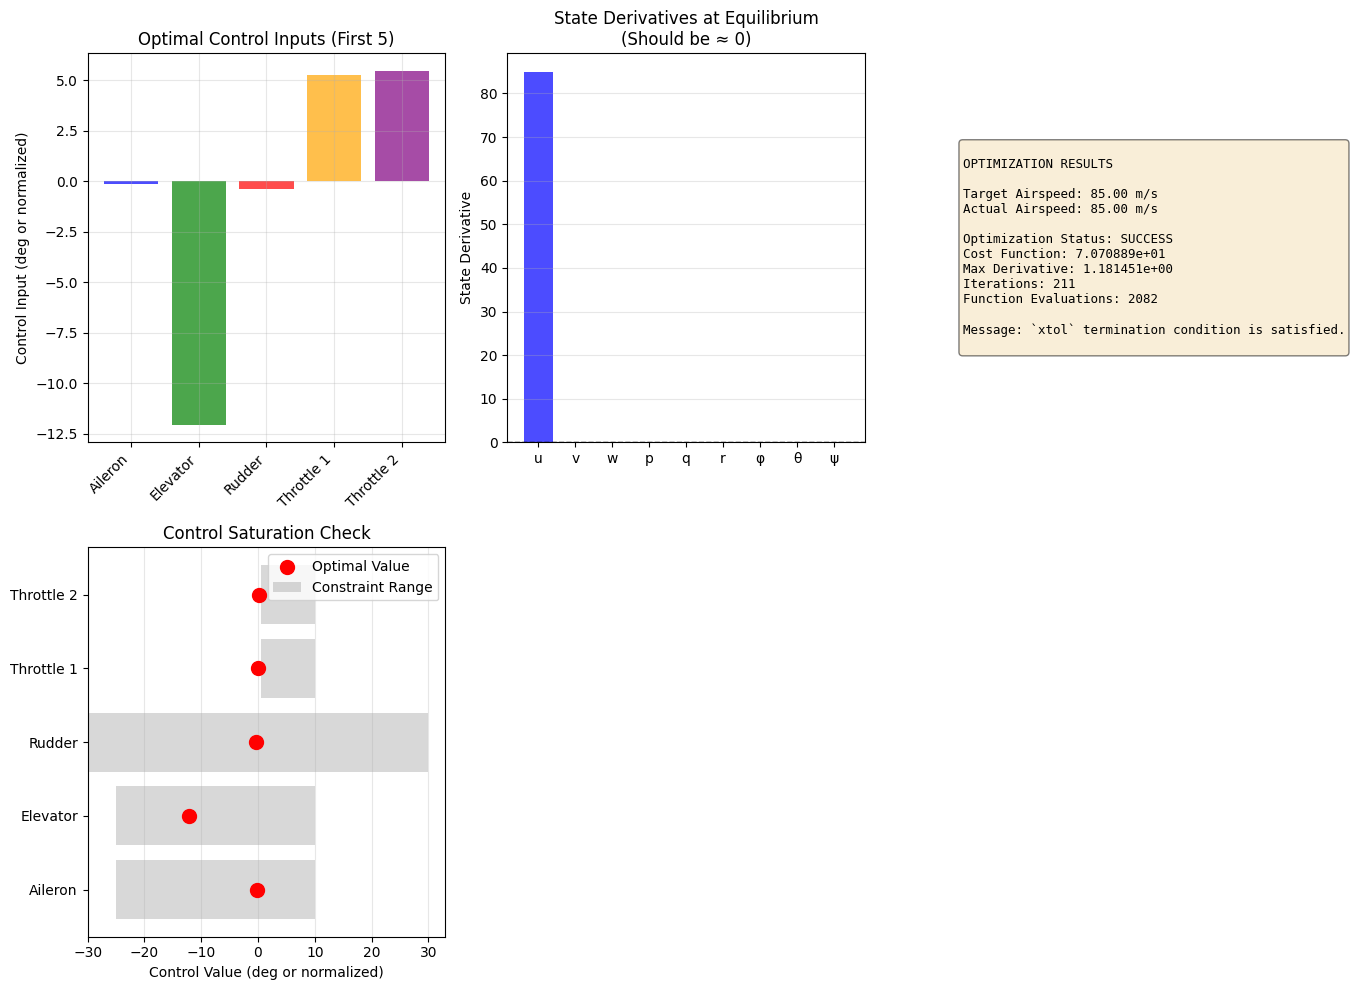

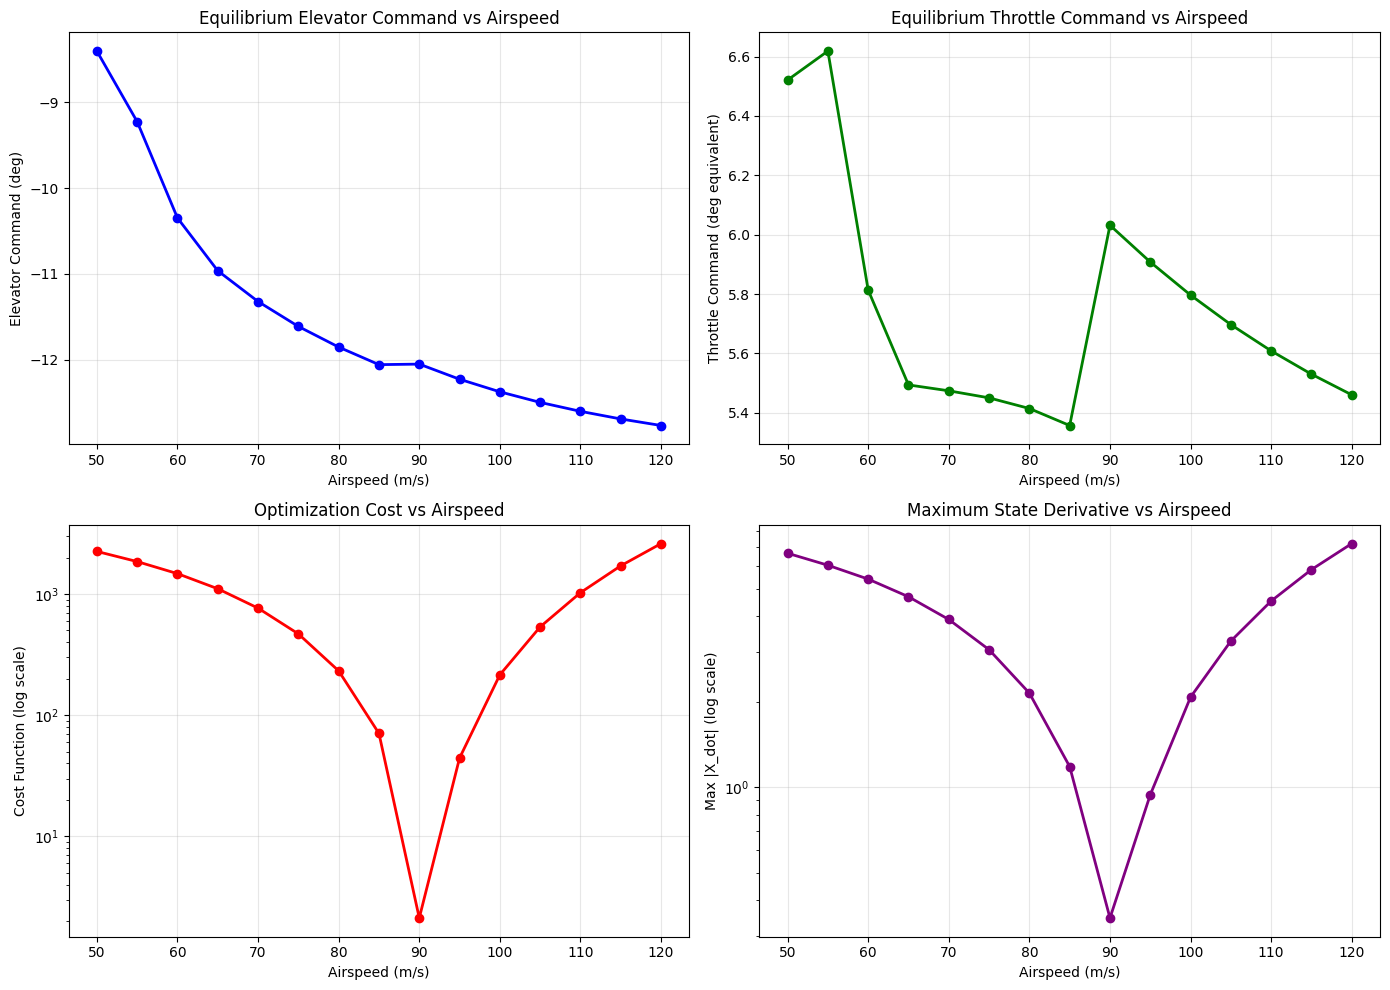

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/rcam/"

if PROJECT_ROOT not in sys.path:
  sys.path.insert(0, PROJECT_ROOT)


import equilibrum
import importlib;
importlib.reload(equilibrum)
from equilibrum import *

# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":

    # Example 1: Single-point equilibrium at 85 m/s
    print("\n" + "="*70)
    print("EXAMPLE 1: Single-Point Equilibrium (85 m/s)")
    print("="*70)

    result_85 = find_equilibrium(target_airspeed=85.0, method='cost_only', verbose=True)

    print(f"\nOptimization Results:")
    print(f"  Success: {result_85['success']}")
    print(f"  Cost: {result_85['cost']:.6e}")
    print(f"  Max State Derivative: {result_85['max_derivative']:.6e}")
    print(f"\nOptimal Control Inputs:")
    print(f"  Aileron: {np.degrees(result_85['U_optimal'][0]):.4f}°")
    print(f"  Elevator: {np.degrees(result_85['U_optimal'][1]):.4f}°")
    print(f"  Rudder: {np.degrees(result_85['U_optimal'][2]):.4f}°")
    print(f"  Throttle 1: {result_85['U_optimal'][3]:.6f}")
    print(f"  Throttle 2: {result_85['U_optimal'][4]:.6f}")


    # Plot single-point result
    fig1 = plot_equilibrium_results(result_85)
    fig1.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_single_point.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_single_point.png")

    # Example 2: Multi-point analysis
    print("\n" + "="*70)
    print("EXAMPLE 2: Multi-Point Equilibrium Analysis")
    print("="*70)

    airspeed_range = np.linspace(50, 120, 15)
    results_multipoint = find_equilibrium_multipoint(airspeed_range=airspeed_range, method='cost_only')

    # Plot multi-point analysis
    fig2 = plot_multipoint_analysis(results_multipoint)
    fig2.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_multipoint.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_multipoint.png")

    # Example 3: Find equilibrium at different airspeeds with better convergence
    print("\n" + "="*70)
    print("EXAMPLE 3: Additional Equilibrium Points")
    print("="*70)

    test_airspeeds = [70, 90, 110]
    for Va in test_airspeeds:
        result = find_equilibrium(target_airspeed=Va, method='cost_only', verbose=False)
        print(f"\nAirspeed {Va} m/s:")
        print(f"  Elevator: {np.degrees(result['U_optimal'][1]):.4f}°")
        print(f"  Throttle Avg: {np.mean(result['U_optimal'][3:5]):.6f}")
        print(f"  Cost: {result['cost']:.6e}")

    # Export equilibrium controls to CSV
    print("\n" + "="*70)
    print("EXPORTING RESULTS")
    print("="*70)

    export_data = np.array([[Va,
                             np.degrees(results_multipoint[Va]['U_optimal'][1]),
                             np.mean(results_multipoint[Va]['U_optimal'][3:5]),
                             results_multipoint[Va]['cost'],
                             results_multipoint[Va]['max_derivative']]
                            for Va in sorted(results_multipoint.keys())])

    header = 'airspeed_ms,elevator_deg,throttle_avg,cost,max_derivative'
    np.savetxt('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_commands.csv', export_data,
                delimiter=',', header=header, comments='', fmt='%.6f')
    print("Equilibrium commands saved to equilibrium_commands.csv")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)